In [ ]:
!pip install -U tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 99.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 42.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/Colab Notebooks/COMP4211/project/data"
# data_path = "/content/drive/MyDrive"

wikiart_zip = os.path.join(data_path, 'wikiart.zip')
wikiart_path = "wikiart"

Mounted at /content/drive


In [ ]:
!unzip "$wikiart_zip" > /dev/null 2>&1

In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

from tensorflow.keras.preprocessing.image import array_to_img

# Image handling and visualization
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from IPython.display import display
from tqdm.notebook import tqdm
import cv2

# Other utility
import datetime
import psutil

# Module settings:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # This will hide all TensorFlow messages, except for errors.
tf.get_logger().setLevel('ERROR')  # This sets TensorFlow logger to only output error messages.

import random
random.seed(4211) # For reproducibility

# Utility Function

In [ ]:
# Min-Max normalize the pixel value to -0.5 to 0.5
def preprocess(x):
    x /= 255.0
    x -= 1
    return x

# Min-Max denormalize the pixel value back to 0 to 255
def deprocess(x):
    x += 1
    x *= 255.0
    x = tf.clip_by_value(x, 0.0, 255.0)  # Ensure pixel value range is valid
    return x

# Loads an image from disk, optionally resizes it, and prepares it for the model.
def get_image(img_path, resize=True, shape=(256,256), split_shape=(3,3), remove_section=True, center=True):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB
    if resize:
        image = cv2.resize(image, shape)  # Resize image
    image = image.astype(np.float32)  # Convert to float32 for model compatibility

    # Split the image into a grid
    h, w, _ = image.shape
    grid_h, grid_w = h // split_shape[0], w // split_shape[1]
    grid = [[image[i*grid_h:(i+1)*grid_h if i != split_shape[0]-1 else h, j*grid_w:(j+1)*grid_w if j != split_shape[1]-1 else w] for j in range(split_shape[1])] for i in range(split_shape[0])]

    # Randomly remove a section
    if remove_section:
        i, j = np.random.randint(0, split_shape[0]), np.random.randint(0, split_shape[1])
        if center:
            i = 1
            j = 1
        grid[i][j] = np.zeros_like(grid[i][j])

    # Combine the grid back into an image
    image = np.concatenate([np.concatenate(row, axis=1) for row in grid], axis=0)

    return image

# Finds and returns a list of images (files) within a directory path that matches a certain file type.
def find_images(dir_path, file_type):
    image_paths = []

    for root, _, files in os.walk(dir_path):
        for file in files:
            if f'.{file_type}' in file:
                image_paths.append(os.path.join(root, file))

    return image_paths


In [ ]:
def show_image(img, img_name='Image name'):
    plt.imshow(img.astype(int))
    plt.title(img_name)
    plt.show()

# Get a list of all image paths
image_paths = find_images(wikiart_path, 'jpg')
print(len(image_paths))

7492


# Wikiart Dataset

Data Loader with PyDataset:

In [ ]:
import keras
class WikiArtDataset(keras.utils.PyDataset):
    def __init__(self, image_paths, batch_size=16, shape=(128,128), split_shape=(3,3), shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.shape = shape
        self.split_shape = split_shape
        self.shuffle = shuffle
        self.on_epoch_end()

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_paths)

    def __len__(self):
        # trim last batch (if it exists) with uneven length
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        low = idx * self.batch_size
        high = low + self.batch_size
        batch_image_paths = image_paths[low:high]
        x_train = []
        y_train = []
        for path in batch_image_paths:
            x_train.append(preprocess(get_image(path, resize=True, shape=self.shape, split_shape=(3,3), remove_section=True)))
            y_train.append(preprocess(get_image(path, resize=True, shape=self.shape, split_shape=(3,3), remove_section=False)))
        return np.array(x_train), np.array(y_train)

In [ ]:
dataset_params = {
    'batch_size': 16,
    'shape': (64,64),
    'split_shape': (3,3),
    'shuffle': True
}
random.shuffle(image_paths)
train_image_paths = image_paths[:5000] # 70-30 split on randomized datapaths
test_image_paths = image_paths[5000:]
train_dataset = WikiArtDataset(image_paths=train_image_paths, **dataset_params)
test_dataset = WikiArtDataset(image_paths=test_image_paths, **dataset_params)
x_train, y_train = train_dataset.__getitem__(0)
x_test, y_test = test_dataset.__getitem__(0)

In [ ]:
# Check if the shape is correct
print(x_train[0].shape)
print(y_train[0].shape)

(64, 64, 3)
(64, 64, 3)


# Vanilla Convolutional Autoencoder (U-net)

https://wandb.ai/wandb_fc/articles/reports/Introduction-to-image-inpainting-with-deep-learning--Vmlldzo1NDI3MjA5


Model (U-net):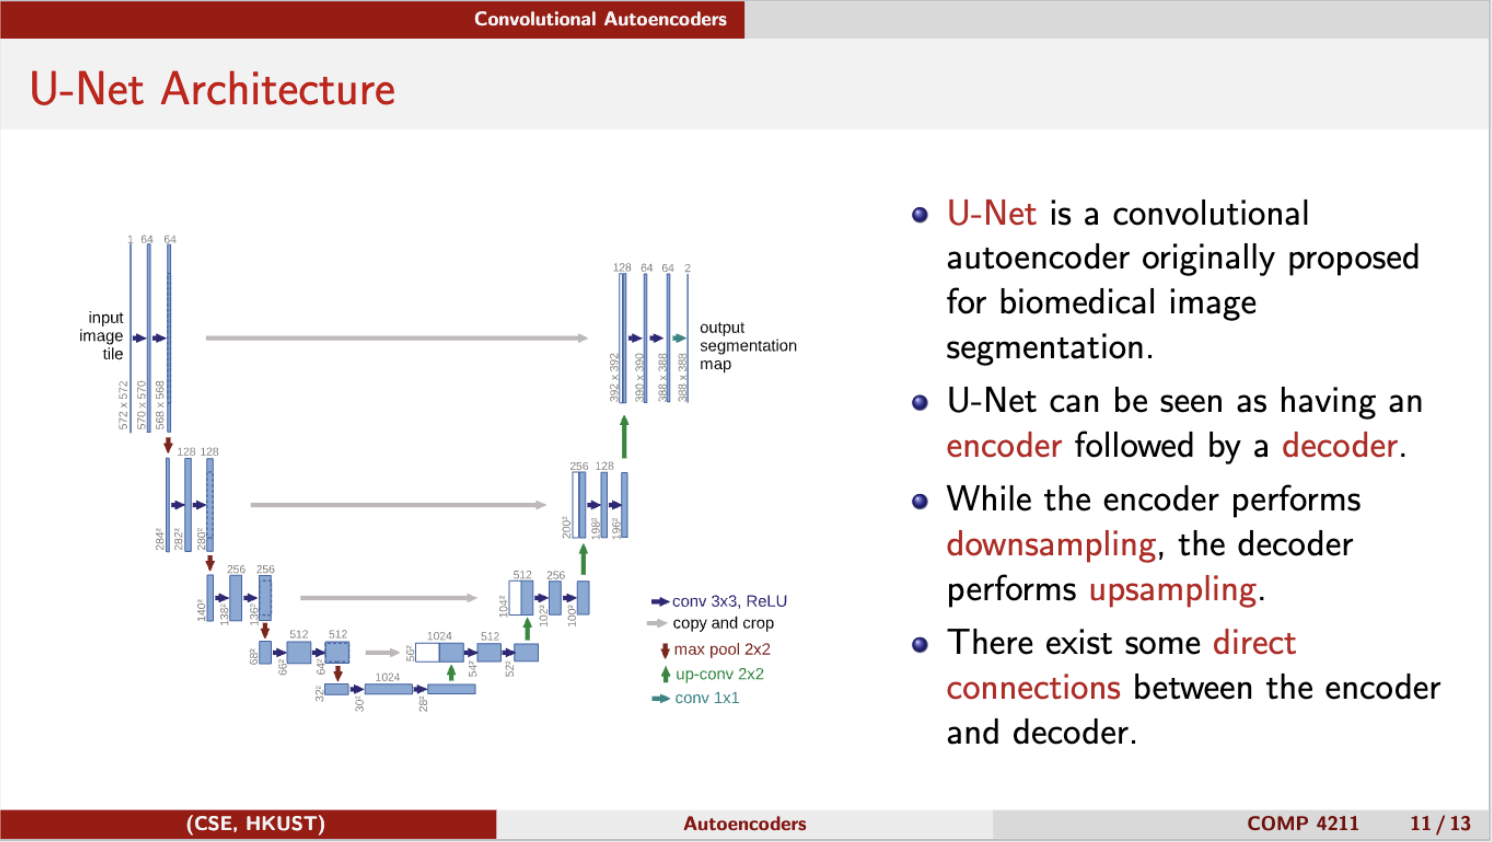


But we pad with same padding to obtain the same output size as input size

In [ ]:
class Inpainting_Vanilla_Autoencoder:
    def get_model(self, shape):
        inputs = keras.layers.Input(shape)

        down1_conv, down1_pool = self._downsampling_block(previous_output=inputs, filters=64)
        down2_conv, down2_pool = self._downsampling_block(previous_output=down1_pool, filters=128)
        down3_conv, down3_pool = self._downsampling_block(previous_output=down2_pool, filters=256)
        down4_conv, down4_pool = self._downsampling_block(previous_output=down3_pool, filters=512)

        down5_conv = self._downsampling_block(previous_output=down4_pool, filters=1024, pool=False)
        up4_pool = self._upsampling_block(previous_output=down5_conv, concat=down4_conv, filters=512)
        up3_pool = self._upsampling_block(previous_output=up4_pool, concat=down3_conv, filters=256)
        up2_pool = self._upsampling_block(previous_output=up3_pool, concat=down2_conv, filters=128)
        up1_pool = self._upsampling_block(previous_output=up2_pool, concat=down1_conv, filters=64)

        outputs = keras.layers.Conv2D(filters=3, kernel_size=(3,3), padding='same')(up1_pool)

        return keras.Model(inputs=[inputs], outputs=[outputs])

    def _downsampling_block(self, previous_output, filters, kernel_size=(3,3), dilation_rate=(1,1)
                            , padding="same", activation='relu', pool=True, pool_size=(2,2)):
        conv1 = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, activation=activation)(previous_output) # add dilation for experiments here
        conv2 = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, activation=activation)(conv1) # add dilation for experiments here
        if pool:
            pool1 = keras.layers.MaxPooling2D(pool_size=pool_size)(conv2)
            return conv2, pool1 # return conv result for concatenation, pool result for next layer
        else:
            return conv2 # for latent variable in encoded result, no need pooling to save computations

    def _upsampling_block(self, previous_output, filters, concat=None, kernel_size=(3,3), dilation_rate=(1,1)
                            , padding="same", activation='relu', pool=True, strides=(2,2)):
        pool1 = keras.layers.Conv2DTranspose(filters=filters,kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, activation=activation, strides=strides)(previous_output)
        # concat = keras.layers.Resizing(pool1.shape[1], pool1.shape[2], 3)(concat) # no need in this revised model
        concat_pool1 = keras.layers.concatenate([concat, pool1], axis=3)
        conv2 = keras.layers.Conv2D(filters=filters,kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, activation=activation)(concat_pool1)
        conv1 = keras.layers.Conv2D(filters=filters,kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, activation=activation)(conv2)
        return conv1

In [ ]:
model_params = {
    "shape": (64,64,3)
}
keras.backend.clear_session()
autoencoder_model_L1 = Inpainting_Vanilla_Autoencoder().get_model(**model_params)
autoencoder_model_L1.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mean_absolute_error')
autoencoder_model_L1.summary()
# somehow plotting model doesn't work?
# keras.utils.plot_model(autoencoder_model, show_shapes=True, to_file='/content/drive/MyDrive/Colab Notebooks/COMP4211/project/unet_model.png')
autoencoder_model_L2 = Inpainting_Vanilla_Autoencoder().get_model(**model_params)
autoencoder_model_L2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mean_squared_error')
autoencoder_model_L2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 16, 16, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 8, 8, 256)      │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 8, 8, 512)      │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 8, 8, 512)      │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 4, 4, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 4, 4, 1024)     │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 4, 4, 1024)     │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 8, 8, 512)      │      4,719,104 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 8, 8, 1024)     │              0 │ conv2d_7[0][0],        │
│                      

 Total params: 34,515,011 (131.66 MB)

 Trainable params: 34,515,011 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 64, 64, 64)     │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 32, 32, 64)     │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 32, 32, 128)    │        147,584 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 16, 16, 128)    │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 16, 16, 256)    │        590,080 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 8, 8, 256)      │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 8, 8, 512)      │      1,180,160 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 8, 8, 512)      │      2,359,808 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 4, 4, 512)      │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 4, 4, 1024)     │      4,719,616 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 4, 4, 1024)     │      9,438,208 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 8, 8, 512)      │      4,719,104 │ conv2d_28[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4        

 Total params: 34,515,011 (131.66 MB)

 Trainable params: 34,515,011 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

Load trained weights

In [ ]:
# modify to the correct path for use
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/COMP4211/project/model/unet.weights.h5'
autoencoder_model_L1.load_weights(checkpoint_filepath)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Use Wandb for visualization (require login):

In [ ]:
import wandb
from wandb.keras import WandbMetricsLogger
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="comp4211_project_image_inpainting",

    # track hyperparameters and run metadata
    config={
        "learning_rate": 1e-3,
        "architecture": "U-net vanilla autoencoder",
        "dataset": "WikiArt",
        "epochs": 20,
    }
)

wandb: Currently logged in as: tyeung-machinelearning (tyeung). Use `wandb login --relogin` to force relogin


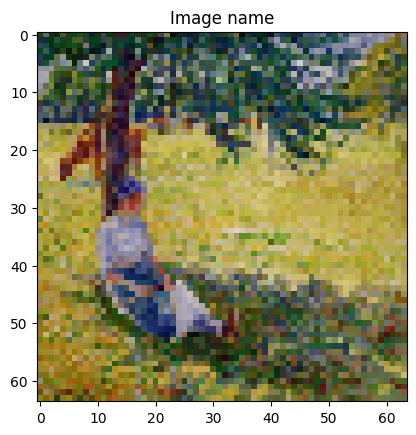

In [ ]:
sample_idx = 211
sample_images, sample_labels = test_dataset[sample_idx]
show_image(np.array(deprocess(sample_labels[0])))

In [ ]:
class PredictionLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PredictionLogger, self).__init__()

    def on_epoch_end(self, logs, epoch):

        images = []
        labels = []
        predictions = []

        for i in range(16):
            inpainted_image = self.model.predict(np.expand_dims(sample_images[i], axis=0))
            images.append(sample_images[i])
            labels.append(sample_labels[i])
            predictions.append(inpainted_image.reshape(inpainted_image.shape[1:]))

        wandb.log({"images": [wandb.Image(image)
                              for image in images]})
        wandb.log({"labels": [wandb.Image(label)
                              for label in labels]})
        wandb.log({"predictions": [wandb.Image(deprocess(inpainted_image))
                              for inpainted_image in predictions]})

In [ ]:
Model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

autoencoder_model_L1.fit(
    x=train_dataset,
    validation_data=test_dataset,
    epochs=1,
    callbacks=[
        WandbMetricsLogger(),
        PredictionLogger(),
        Model_checkpoint_callback]
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
312/312 ━━━━━━━━━━━━━━━━━━━━ 266s 842ms/step - loss: 0.0345 - val_loss: 0.0377


In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="comp4211_project_image_inpainting",

    # track hyperparameters and run metadata
    config={
        "learning_rate": 1e-3,
        "architecture": "U-net vanilla autoencoder",
        "dataset": "WikiArt",
        "epochs": 20,
    }
)
autoencoder_model_L2.fit(
    x=train_dataset,
    validation_data=test_dataset,
    epochs=20,
    callbacks=[
        WandbMetricsLogger(),
        PredictionLogger(),
        Model_checkpoint_callback]
)

# Autoencoder with GAN loss

In [ ]:
def conv(filters, kernel_size, strides=(2, 2), padding="same", batch_norm=True, init_zero_weights=False, use_bias=False, activation='relu'):
    layers = []
    conv_layer = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=use_bias, activation=activation)
    layers.append(conv_layer)

    if batch_norm: # Add optional batch normalization
        layers.append(keras.layers.BatchNormalization())

    return keras.Sequential(layers)

class DCDiscriminator(keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(filters=32, kernel_size=(4,4))
        self.conv2 = conv(filters=64, kernel_size=(4,4))
        self.conv3 = conv(filters=128, kernel_size=(4,4))
        self.conv4 = conv(filters=256, kernel_size=(4,4))
        self.conv5 = conv(filters=1, kernel_size=(4,4), batch_norm=False, padding="valid")

    def call(self, inputs):
        out = self.conv1(inputs)
        # print(out.shape)
        out = self.conv2(out)
        # print(out.shape)
        out = self.conv3(out)
        # print(out.shape)
        out = self.conv4(out)
        # print(out.shape)
        out = self.conv5(out)
        # print(out.shape)
        out = keras.activations.sigmoid(out)
        return out

In [ ]:
def create_model():
    G = Inpainting_Vanilla_Autoencoder().get_model(**model_params)
    D = DCDiscriminator()
    return G, D
# keras.utils.plot_model(D, show_shapes=True, to_file='/content/drive/MyDrive/Colab Notebooks/COMP4211/project/discriminator.png')


Reference: https://www.tensorflow.org/tutorials/generative/dcgan

In [ ]:
D_real_losses = []
D_fake_losses = []
D_total_losses = []
G_losses = []
mse_loss = keras.losses.MeanSquaredError()
mae_loss = keras.losses.MeanAbsoluteError()
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)
G, D = create_model()

def show(img):
    show_image(np.array(deprocess(img)))

def train(train_dataset, epochs=20):
    G, D = create_model()
    train_iters = train_dataset.__len__()
    total_train_iters = train_dataset.__len__() * epochs
    log_step = 10
    iteration = 0
    lambda_rec = 1 # parameters for joint loss
    lambda_adv = 0.0001
    for epoch in range(epochs):

        for i in range(train_iters):
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                ################################################
                ###         TRAIN THE DISCRIMINATOR         ####
                ################################################
                # 1. Compute the discriminator loss on real images
                real_images = train_dataset.__getitem__(i)[1]
                # show(real_images[0])
                # print('real: ', D(real_images))
                D_real_loss = mse_loss(D(real_images), tf.ones_like(16))

                # 2. Compute the discriminator loss on the fake images
                fake_images = G(train_dataset.__getitem__(i)[0], training=True)
                # show(fake_images[0])
                D_fake_loss = mse_loss(D(fake_images, training=True), tf.zeros_like(16))
                # print('fake: ', D(fake_images))

                # 3. Compute the total discriminator loss
                D_total_loss = (D_real_loss + D_fake_loss) / 2.0
                ###########################################
                ###          TRAIN THE GENERATOR        ###
                ###########################################
                fake_images = G(train_dataset.__getitem__(i)[0], training=True)
                # 1. Compute the generator loss
                G_loss = lambda_adv * mse_loss(D(fake_images), tf.ones_like(16))
                # 2. Add the reconstruction loss
                G_loss += lambda_rec * mae_loss(fake_images, real_images)

            gradients_of_generator = gen_tape.gradient(G_loss, G.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(D_total_loss, D.trainable_variables)

            generator_optimizer.apply_gradients(zip(gradients_of_generator, G.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, D.trainable_variables))

            D_real_losses.append(D_real_loss.numpy().item())
            D_fake_losses.append(D_fake_loss.numpy().item())
            D_total_losses.append(D_total_loss.numpy().item())
            G_losses.append(G_loss.numpy().item())
            # Print the log info
            if iteration % log_step == 0:
                print('Iteration [{:4d}/{:4d}] | D_real_loss: {:6.4f} | D_fake_loss: {:6.4f} | G_loss: {:6.4f}'.format(
                       iteration, total_train_iters, D_real_loss.numpy().item(), D_fake_loss.numpy().item(), G_loss.numpy().item()))
                show(real_images[0])
                show(fake_images[0])

            iteration += 1

In [ ]:
train(train_dataset, epochs=20)

In [ ]:
# sample_img, sample_labels = test_dataset[0]
# results = G(sample_img)

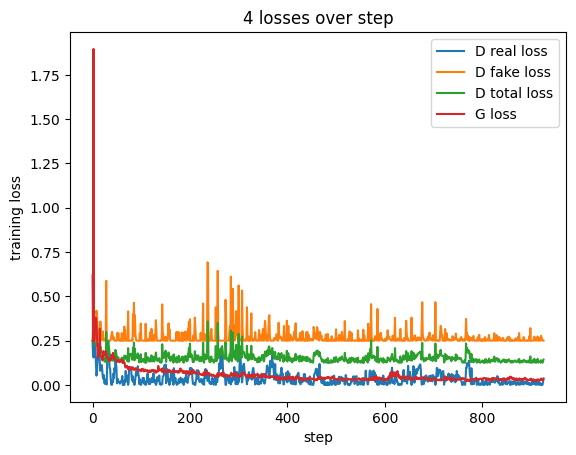

In [ ]:
# plot the loss
plt.plot(D_real_losses, label='D real loss')
plt.plot(D_fake_losses, label='D fake loss')
plt.plot(D_total_losses, label='D total loss')
plt.plot(G_losses, label='G loss')
plt.title('4 losses over step')
plt.xlabel('step')
plt.ylabel('training loss')

plt.legend()

#VAE

https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

https://www.analyticsvidhya.com/blog/2023/07/an-overview-of-variational-autoencoders/


#Taken inspiration and help from :

https://github.com/keras-team/keras-io/blob/master/examples/generative/vae.py

In [ ]:
import math
from keras import ops
from keras import layers

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

class MeanAbsoluteErrorLayer(keras.layers.Layer):
    def call(self, inputs):
        x, x_decoded_mean = inputs
        return keras.losses.mean_absolute_error(x, x_decoded_mean)

class OutputLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv = keras.layers.Conv2D(filters=3, kernel_size=(3,3), padding='same')

    def call(self, inputs_array):
        up1_pool, inputs, z_mean, z_log_var = inputs_array
        outputs = self.conv(up1_pool)
        self.add_loss(self._vae_loss(inputs, outputs, z_mean, z_log_var))
        return outputs

    def _vae_loss(self, x, x_decoded_mean, z_mean, z_log_var):
        mae = MeanAbsoluteErrorLayer()([x, x_decoded_mean])
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        return 10*kl_loss#mae + kl_loss

class Inpainting_VAE_Autoencoder:

    def get_model(self, shape, latent_dim):
        inputs = keras.layers.Input(shape)

        down1_conv, down1_pool = self._downsampling_block(previous_output=inputs, filters=64)
        down2_conv, down2_pool = self._downsampling_block(previous_output=down1_pool, filters=128)
        down3_conv, down3_pool = self._downsampling_block(previous_output=down2_pool, filters=256)
        down4_conv, down4_pool = self._downsampling_block(previous_output=down3_pool, filters=512)

        down5_conv = self._downsampling_block(previous_output=down4_pool, filters=1024, pool=False)

        # Store the shape just before flattening
        pre_flatten_shape = tf.keras.backend.int_shape(down5_conv)[1:]
        flattened_size = pre_flatten_shape[0] * pre_flatten_shape[1] * pre_flatten_shape[2]

        # In the VAE model, the deepest layer is replaced by the latent space
        # The latent space is defined by the mean and log variance of a Gaussian distribution
        z_mean, z_log_var = self._encoding_block(previous_output=down5_conv, latent_dim=latent_dim)
        # The actual latent vector is sampled from the Gaussian defined by the mean and log variance
        # z = self._sampling_block(z_mean, z_log_var)
        z = Sampling()([z_mean, z_log_var])

        # Add a dense layer to transform z into a vector of the appropriate size
        z = keras.layers.Dense(flattened_size, activation='relu')(z)

        # Reshape z to have the dimensions of the encoder output before flattening
        z = keras.layers.Reshape(pre_flatten_shape)(z)

        up4_pool = self._upsampling_block(previous_output=z, concat=down4_conv, filters=512)
        up3_pool = self._upsampling_block(previous_output=up4_pool, concat=down3_conv, filters=256)
        up2_pool = self._upsampling_block(previous_output=up3_pool, concat=down2_conv, filters=128)
        up1_pool = self._upsampling_block(previous_output=up2_pool, concat=down1_conv, filters=64)

        outputs = OutputLayer()([up1_pool, inputs, z_mean, z_log_var])

        model = keras.Model(inputs=[inputs], outputs=[outputs])
        # The loss function for a VAE includes a term for the reconstruction loss (as in a normal autoencoder)
        # and a term for the Kullback-Leibler divergence, which is a measure of how much the learned latent distribution
        # deviates from the prior distribution (in this case, a standard normal distribution)

        return model

    def _downsampling_block(self, previous_output, filters, kernel_size=(3,3), dilation_rate=(1,1)
                            , padding="same", activation='relu', pool=True, pool_size=(2,2)):
        conv1 = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, activation=activation)(previous_output)
        conv2 = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, activation=activation)(conv1)
        if pool:
            pool1 = keras.layers.MaxPooling2D(pool_size=pool_size)(conv2)
            return conv2, pool1
        else:
            return conv2

    def _upsampling_block(self, previous_output, filters, concat=None, kernel_size=(3,3), dilation_rate=(1,1)
                            , padding="same", activation='relu', pool=True, strides=(2,2)):
        pool1 = keras.layers.Conv2DTranspose(filters=filters,kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, activation=activation, strides=strides)(previous_output)
        concat = keras.layers.Resizing(pool1.shape[1], pool1.shape[2])(concat)
        concat_pool1 = keras.layers.concatenate([concat, pool1], axis=3)
        conv2 = keras.layers.Conv2D(filters=filters,kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, activation=activation)(concat_pool1)
        conv1 = keras.layers.Conv2D(filters=filters,kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, activation=activation)(conv2)
        return conv1

    def _encoding_block(self, previous_output, latent_dim):
        x = keras.layers.Flatten()(previous_output)
        num_units = int(math.sqrt(512 + latent_dim))
        x = keras.layers.Dense(num_units, activation="relu")(x)  # Add this line
        z_mean = keras.layers.Dense(latent_dim, name="z_mean")(x)
        z_log_var = keras.layers.Dense(latent_dim, name="z_log_var")(x)
        return z_mean, z_log_var

    # def _sampling_block(self, z_mean, z_log_var):
    #     print(z_mean)
    #     batch = ops.shape(z_mean)[0]
    #     dim = ops.shape(z_mean)[1]

    #     print(batch, dim)
    #     epsilon = keras.random.normal(shape=(batch, dim), seed=4211)
    #     return z_mean + ops.exp(0.5 * z_log_var) * epsilon

    def _vae_loss(self, x, x_decoded_mean, z_mean, z_log_var):
        mae = MeanAbsoluteErrorLayer()([x, x_decoded_mean])
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        return mae + kl_loss

In [ ]:
model_params_2 = {
    "shape":(64,64,3),
    "latent_dim":100
}
keras.backend.clear_session()
model2 = Inpainting_VAE_Autoencoder().get_model(**model_params_2)
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mean_absolute_error')
model2.summary()
# somehow plotting model doesn't work?
# keras.utils.plot_model(model, show_shapes=True, to_file='/content/drive/MyDrive/Colab Notebooks/COMP4211/project/unet_model.png')

NameError: name 'Inpainting_VAE_Autoencoder' is not defined

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/COMP4211/project/model/unet_vae_addloss_onlyKLx10.weights.h5'

if os.path.exists(checkpoint_filepath):
    model2.load_weights(checkpoint_filepath)
else:
    print(f"No weights file found at {checkpoint_filepath}")

In [ ]:
wandb.init(
    project="UNET_VAE",
    config={
        "learning_rate": 0.001,
        "architecture": "U-net VAE add loss no KL",
        "dataset": "WikiArt",
        "epochs": 20,
    }
)

In [ ]:
Model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

model2.fit(
    x=train_dataset,
    validation_data=test_dataset,
    epochs=20,
    callbacks=[
        WandbMetricsLogger(),
        PredictionLogger(),
        Model_checkpoint_callback]
)